# **RNN Classifier for Tweet Data**

This notebook trains the model for an RNN classifier of our data. Word vectorization and recurrent neural network setup followed from youtube.

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html


https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L15/1_lstm.ipynb

See data here: https://docs.google.com/spreadsheets/d/1_uKMj7TnxwBLrJcUChqiTnNc_sqhZYmCAj98H8CrxUY/edit?usp=sharing


First install old version of torchtext because new ones have issues with legacy tools.

In [11]:
!pip install torchtext==0.6.0

Import necessary libraries

In [12]:
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd

Code for helper functions

In [13]:
import re

def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove special characters, newlines, and punctuations
    tweet = re.sub(r"(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+", "", tweet)
    # Remove extra whitespaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

In [14]:
clean_tweet('#63millionbabies  who have been killed by ROE \n#RoeVWade \n#SupremeCourt')

'63millionbabies who have been killed by ROE RoeVWade SupremeCourt'

Settings for different parameters.

In [15]:
##### select regularization type and strength
L1_REG = False
L1_PENALTY= 5e-6

L2_REG = True
L2_PENALTY = 8e-5

# select cleaned or uncleaned
IS_CLEAN = True

# select data balancing choice ("deletion" or "duplication", otherwise, no balancing)
BALANCE_CHOICE = "deletion"

# select dropout rate
DROPOUT_RATE = 0

# number of layers
NUM_LAYERS = 1

# Seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Vocabulary size
VOCABULARY_SIZE = 3000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2
DATA_PATH = "./tweets.csv"

## Setup and Format Data


Balance data by either duplication or deletion (to prevent overfitting)

In [16]:
df = pd.read_csv(DATA_PATH)

# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Count minority labels
minority_label = label_counts.idxmin()
minority_count = label_counts.min()

if BALANCE_CHOICE == "deletion":
  # Find indices of the majority class to delete excess samples
  majority_indices = df[df['label'] != minority_label].index
  excess_majority_indices = majority_indices[minority_count:]

  # Delete excess samples from the majority class to balance the dataset
  balanced_df = df.drop(excess_majority_indices)
  balanced_df.to_csv("./tweetsDEL.csv", index=False)
  DATA_PATH = "./tweetsDEL.csv"
elif BALANCE_CHOICE == "duplication":
  # Find indices of the minority class to delete excess samples
  minority_indices = df[df['label'] == minority_label].index

  # duplicate samples from minority class
  count_difference = abs(label_counts[0] - label_counts[1])
  duplicate_indices = pd.Series(minority_indices).sample(n=count_difference, replace=True).values
  duplicated_samples = df.loc[duplicate_indices]
  balanced_df = df.append(duplicated_samples, ignore_index=True)

  balanced_df.to_csv("./tweetsDUP.csv", index=False)
  DATA_PATH = "./tweetsDUP.csv"

# Verify the new class distribution
print(balanced_df['label'].value_counts())

label
0    8816
1    8816
Name: count, dtype: int64


Additional cleaning to data

In [17]:
if IS_CLEAN:
  df = pd.read_csv(DATA_PATH)
  df["text"] = df["text"].apply(clean_tweet)
  df.to_csv(DATA_PATH, index=False) # don't write another df index column



Define text and label formatters

In [18]:
TEXT = torchtext.data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm')
LABEL = torchtext.data.LabelField(dtype=torch.long)

Process/format data.

In [19]:
fields = [("text", TEXT), ("label", LABEL)]

dataset = torchtext.data.TabularDataset(
    path=DATA_PATH, format='csv',
    skip_header=True, fields=fields)




## Split Dataset into Test/Train/Validation sets

Test/Train split


In [20]:
train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

Split train into training and validation sets.

In [21]:
train_data, valid_data = train_data.split(
    split_ratio=[0.8, 0.20],
    random_state=random.seed(RANDOM_SEED))

Show sizes of sets and example text data.

In [22]:
print(f'Test Size: {len(train_data)}')
print(f'Train Size: {len(train_data)}')
print(f'Validation Size: {len(valid_data)}')
print(vars(train_data.examples[2]))

Test Size: 11285
Train Size: 11285
Validation Size: 2821
{'text': ['63millionbabies', 'who', 'have', 'been', 'killed', 'by', 'ROE', 'RoeVWade', 'SupremeCourt'], 'label': '1'}


## Build Vocabulary
Valid words are the top frequent VOCABULARY_SIZE words.

In [23]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data, max_size = 2)
print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Label size: {len(LABEL.vocab)}')
print(TEXT.vocab.freqs.most_common(20)) # most common words

Vocabulary size: 3002
Label size: 2
[('the', 12446), ('to', 11150), ('abortion', 7574), ('a', 6462), ('of', 6390), ('is', 6236), ('and', 6176), ('in', 4528), ('I', 4061), ('that', 3898), ('for', 3872), ('nt', 2937), ('you', 2908), ('are', 2865), ('Roe', 2521), ('have', 2459), ('not', 2385), ('be', 2282), ('it', 2230), ('on', 2218)]


In [24]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(TEXT.vocab.stoi['the'])
print(LABEL.vocab.stoi)
LABEL.vocab.freqs

[('the', 12446), ('to', 11150), ('abortion', 7574), ('a', 6462), ('of', 6390), ('is', 6236), ('and', 6176), ('in', 4528), ('I', 4061), ('that', 3898), ('for', 3872), ('nt', 2937), ('you', 2908), ('are', 2865), ('Roe', 2521), ('have', 2459), ('not', 2385), ('be', 2282), ('it', 2230), ('on', 2218)]
['<unk>', '<pad>', 'the', 'to', 'abortion', 'a', 'of', 'is', 'and', 'in']
2
defaultdict(None, {'1': 0, '0': 1})


Counter({'1': 5694, '0': 5591})

## Data Loader


In [25]:
train_loader, valid_loader, test_loader = \
    torchtext.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.text),
         device=DEVICE
    )

In [26]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.text.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.text.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.text.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([56, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([8, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([8, 128])
Target vector size: torch.Size([128])


## Build Neural Network

In [27]:
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        # self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, dropout=DROPOUT_RATE)
        #self.rnn = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=NUM_LAYERS)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)



    def forward(self, text):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.fc(hidden)
        return output

In [28]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # use weight decay for l2 regularization

## Train Neural Network

Function for L1 regularization term

In [29]:
def l1_term(model, l1_penalty):
  l1_loss = 0
  for param in model.parameters():
    l1_loss += torch.sum(torch.abs(param))
  return l1_penalty * l1_loss


Function for L2 regularization term

In [30]:
def l2_term(model, l2_penalty):
    l2_loss = 0.0
    for param in model.parameters():
        l2_loss += torch.sum(param ** 2)
    return 0.5 * l2_penalty * l2_loss

In [31]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [32]:
start_time = time.time()

# can cause early stopping by decreasing number of epochs 
for epoch in range(NUM_EPOCHS+3):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):

        text = batch_data.text.to(DEVICE)
        labels = batch_data.label.to(DEVICE)

        ### FORWARD AND BACK PROP

        logits = model(text)

        # regularization (optional)
        loss = F.cross_entropy(logits, labels) # cross entropy loss tends to be better for classification problems

        if L1_REG:
          loss += l1_term(model, L1_PENALTY)

        if L2_REG:
          loss += l2_term(model, L2_PENALTY)

        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')


print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')
print(f'Train accuracy: {compute_accuracy(model, train_loader, DEVICE):.2f}%')

Epoch: 001/015 | Batch 000/089 | Loss: 16.1749
Epoch: 001/015 | Batch 050/089 | Loss: 11.0299
training accuracy: 50.73%
valid accuracy: 50.80%
Time elapsed: 0.21 min
Epoch: 002/015 | Batch 000/089 | Loss: 8.2894
Epoch: 002/015 | Batch 050/089 | Loss: 5.8429
training accuracy: 49.57%
valid accuracy: 49.77%
Time elapsed: 0.41 min
Epoch: 003/015 | Batch 000/089 | Loss: 4.5143
Epoch: 003/015 | Batch 050/089 | Loss: 3.3088
training accuracy: 50.73%
valid accuracy: 50.37%
Time elapsed: 0.62 min
Epoch: 004/015 | Batch 000/089 | Loss: 2.6348
Epoch: 004/015 | Batch 050/089 | Loss: 2.0254
training accuracy: 49.58%
valid accuracy: 49.56%
Time elapsed: 0.80 min
Epoch: 005/015 | Batch 000/089 | Loss: 1.6865
Epoch: 005/015 | Batch 050/089 | Loss: 1.3742
training accuracy: 50.71%
valid accuracy: 50.09%
Time elapsed: 0.98 min
Epoch: 006/015 | Batch 000/089 | Loss: 1.1969
Epoch: 006/015 | Batch 050/089 | Loss: 1.0418
training accuracy: 54.53%
valid accuracy: 49.63%
Time elapsed: 1.16 min
Epoch: 007/015

## Testing and Analysis

First test on basic examples with predict_side function (closer to 1 means pro-life, closer to 0 means pro-choice)

In [42]:
import spacy
nlp = spacy.blank("en")

# function for side prediction (based vectorization of text from tutorial)
def predict_side(model, sentence):
    model.eval()
    tokenized = [token.text for token in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][0].item()


Test on basic phrases

In [43]:
print('Score/Probability Pro-Life:')
prompts = ["women's rights are so important", 
           "my body my choice, the government should keep their hands off women", 
           "God loves babies thank god",
          "We have cats, cats are really cute and fuzzy",
          "Potatoes", 
          "According to all known laws of aviation, a bee should not be able to fly."]

for prompt in prompts:
    score = predict_side(model, prompt)
    print("{:85} {}".format(prompt, score))


Score/Probability Pro-Life:
women's rights are so important                                                       0.2429903745651245
my body my choice, the government should keep their hands off women                   0.34514573216438293
God loves babies thank god                                                            0.7602097988128662
We have cats, cats are really cute and fuzzy                                          0.42585113644599915
Potatoes                                                                              0.5442848205566406
According to all known laws of aviation, a bee should not be able to fly.             0.4795265197753906


Now test out how the model interprets cats (should have little effect).

In [44]:
# torch.save(model.state_dict(), 'RNN_deletion.pth')
print("{:85} {}".format("Prompt", "Output"))
for cat_count in range(10):
    prompt = f"God and the holy spirit love babies " + ("cats " * cat_count)
    result = predict_side(model, prompt)
    print("{:85} {}".format(prompt, result))

Prompt                                                                                Output
God and the holy spirit love babies                                                   0.7531561255455017
God and the holy spirit love babies cats                                              0.8430856466293335
God and the holy spirit love babies cats cats                                         0.8669992685317993
God and the holy spirit love babies cats cats cats                                    0.8663495779037476
God and the holy spirit love babies cats cats cats cats                               0.8658765554428101
God and the holy spirit love babies cats cats cats cats cats                          0.8655753135681152
God and the holy spirit love babies cats cats cats cats cats cats                     0.865012526512146
God and the holy spirit love babies cats cats cats cats cats cats cats                0.8644141554832458
God and the holy spirit love babies cats cats cats cats cats cats ca

In [36]:
#torch.save(model.state_dict(), './model_l2regularization.tar') # save model

# Generate opinion distributions (SKIP HERE FOR RESULTS)

Function for plotting opinion distributions.

In [61]:
conda install -c plotly plotly

Channels:
 - plotly
 - defaults
 - conda-forge
 - fastai
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [62]:
conda install scikit-learn

Channels:
 - defaults
 - conda-forge
 - fastai
 - plotly
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/arjuntaneja/miniconda3/envs/XNNs

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.2.0               |  py311hca03da5_0         519 KB
    numpy-1.24.3               |  py311hb57d4eb_0          12 KB
    numpy-base-1.24.3          |  py311h1d85a46_0         6.9 MB
    scikit-learn-1.3.0         |  py311h7aedaa7_0         8.8 MB
    scipy-1.11.4               |  py311hc76d9b0_0        21.1 MB
    threadpoolctl-2.2.0        |     pyh0d69192_0          16 KB
    ------------------------------------------------------------
                                           Total:        37.4 MB

The following NEW packages will be INSTALLED:

  joblib             pkgs/main/osx-arm64::

In [81]:
conda install seaborn

Channels:
 - defaults
 - conda-forge
 - fastai
 - plotly
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/arjuntaneja/miniconda3/envs/XNNs

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.2.0            |  py311h48ca7d4_0         255 KB
    matplotlib-base-3.8.0      |  py311h7aedaa7_0         7.7 MB
    ------------------------------------------------------------
                                           Total:         8.0 MB

The following NEW packages will be INSTALLED:

  brotli             pkgs/main/osx-arm64::brotli-1.0.9-h1a28f6b_7 
  brotli-bin         pkgs/main/osx-arm64::brotli-bin-1.0.9-h1a28f6b_7 
  contourpy          pkgs/main/osx-arm64::contourpy-1.2.0-py311h48ca7d4_0 
  cycler             pkgs/main/noarch::cycler-0.11.0-pyhd3eb1b0_0 
  fonttools          pkgs/m

In [82]:
conda install matplotlib

Channels:
 - defaults
 - conda-forge
 - fastai
 - plotly
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/arjuntaneja/miniconda3/envs/XNNs

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.8.0           |  py311hca03da5_0           9 KB
    ------------------------------------------------------------
                                           Total:           9 KB

The following NEW packages will be INSTALLED:

  matplotlib         pkgs/main/osx-arm64::matplotlib-3.8.0-py311hca03da5_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [77]:
import plotly.express as px
def view_hist(df, x_axis, color, nbins = 300):
    """
    General histogram generating function data. Can choose dataframe and name of column that creates the x_axis.
    NOTE: do not set log_x to True, it doesn't work with this function.
        INPUTS: df (pandas dataframe), x_axis (string, name of column you want to plot), color (str, column that determines 
                colors of overlaying histogram), log_x (bool, make x-axis log), log_y (bool, make y-axis log).
        RETURNS: None
    """

    fig = px.histogram(df, x=x_axis, color=color, marginal="violin", # can be `box`, `violin`
                         hover_data=df.columns, nbins = nbins, log_y = False, log_x=False)
    fig.update_layout(barmode='overlay')
    
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.5)
    fig.show()

## Re-load model
(Kernel may stop here because of installing the new package)

In [46]:
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)
model.load_state_dict(torch.load("model_l2regularization.tar"))
model.eval()

RNN(
  (embedding): Embedding(3002, 128)
  (rnn): LSTM(128, 256)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [80]:
print('Score/Probability Pro-Life:')
prompts = ["women's rights are so important", 
           "my body my choice, the government should keep their hands off women", 
           "God loves babies thank god",
          "We have cats, cats are really cute and fuzzy",
          "Potatoes", 
          "According to all known laws of aviation, a bee should not be able to fly."]

for prompt in prompts:
    score = predict_side(model, prompt)
    print("{:85} {}".format(prompt, score))

Score/Probability Pro-Life:
women's rights are so important                                                       0.2429903745651245
my body my choice, the government should keep their hands off women                   0.34514573216438293
God loves babies thank god                                                            0.7602097988128662
We have cats, cats are really cute and fuzzy                                          0.42585113644599915
Potatoes                                                                              0.5442848205566406
According to all known laws of aviation, a bee should not be able to fly.             0.4795265197753906


First test on related tweets (SurgeAI dataset: https://www.surgehq.ai/datasets/abortion-tweets-dataset )

In [85]:
# add column for assigning score
df_related = pd.read_csv("SurgeAI_tweets.csv")
df_related.dropna(subset=["text"], inplace=True)
df_related["score"] = df_related["text"].apply(lambda x: predict_side(model, x))
df_related.to_csv("L2reg_scored_SurgeAItweets.csv")
df_related.head(10)

,Unnamed: 0,text,Category,score
0,0,"Delete Facebook, hit the streets https://t.co...",Pro-choice,0.774778
1,1,@Razzaque_Ayesha This was indeed one of the fe...,Pro-life,0.413591
2,2,For context this happened when I told multiple...,Pro-choice,0.289799
3,3,I’m not arguing with anyone about roe v wade. ...,Pro-choice,0.416698
4,4,we been on this! when the issues happened in T...,Pro-choice,0.549221
5,5,@dindin6 @kylegriffin1 Roe v Wade was terrible...,Pro-life,0.628731
6,6,annoyed i can’t voice my opinion on roe v wade...,Pro-choice,0.212200
7,7,@alexismcgill Roe v Wade is no longer. Wonderful!,Pro-life,0.574991
8,8,out here wondering if the supreme court realiz...,Pro-choice,0.183573
9,9,More telling: How the Justices see themselves ...,Pro-choice,0.440313


Next, determine accuracy/confusion matrix on this dataset.

In [86]:
df_related["given_label"] = df_related["score"].apply(round)
df_related["true_label"] = df_related["Category"].apply(lambda x: int(x=="Pro-life"))
df_related.head(10)

,Unnamed: 0,text,Category,score,given_label,true_label
0,0,"Delete Facebook, hit the streets https://t.co...",Pro-choice,0.774778,1,0
1,1,@Razzaque_Ayesha This was indeed one of the fe...,Pro-life,0.413591,0,1
2,2,For context this happened when I told multiple...,Pro-choice,0.289799,0,0
3,3,I’m not arguing with anyone about roe v wade. ...,Pro-choice,0.416698,0,0
4,4,we been on this! when the issues happened in T...,Pro-choice,0.549221,1,0
5,5,@dindin6 @kylegriffin1 Roe v Wade was terrible...,Pro-life,0.628731,1,1
6,6,annoyed i can’t voice my opinion on roe v wade...,Pro-choice,0.212200,0,0
7,7,@alexismcgill Roe v Wade is no longer. Wonderful!,Pro-life,0.574991,1,1
8,8,out here wondering if the supreme court realiz...,Pro-choice,0.183573,0,0
9,9,More telling: How the Justices see themselves ...,Pro-choice,0.440313,0,0


Confusion matrix -- related dataset:
[[499 122]
 [245 159]]


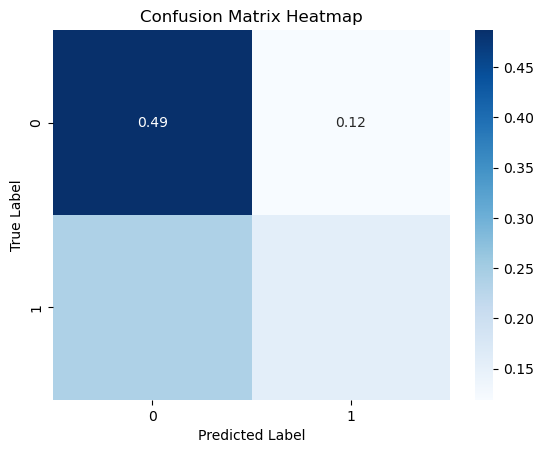

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
conf_matrix = confusion_matrix(df_related["given_label"], df_related["true_label"])
print("Confusion matrix -- related dataset:")
print(conf_matrix)

# create and display heatmap
sns.heatmap(np.array(conf_matrix)/np.sum(conf_matrix), annot=True, cmap='Blues')
# plt.ylim(0,2)
# plt.xlim(0,2)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [97]:
### Unrelated dataset -- Covid19 Tweets

Next test on unrelated dataset (Covid19 tweets)

In [74]:
# add column for assigning score
df_related = pd.read_csv("COVID19_tweets.csv")
df_related = df_related.head(3000)
df_related.dropna(subset=["text"], inplace=True)
df_related["score"] = df_related["text"].apply(lambda x: predict_side(model, x))
df_related.to_csv("L2reg_scored_COVIDtweets.csv")
df_related.head(10)

,Unnamed: 0,text,score
0,0,If I smelled the scent of hand sanitizers toda...,0.492338
1,1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,0.299913
2,2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,0.698814
3,3,@brookbanktv The one gift #COVID19 has give me...,0.825930
4,4,25 July : Media Bulletin on Novel #CoronaVirus...,0.612348
5,5,#coronavirus #covid19 deaths continue to rise....,0.802304
6,6,How #COVID19 Will Change Work in General (and ...,0.271800
7,7,You now have to wear face coverings when out s...,0.451025
8,8,Praying for good health and recovery of @Chouh...,0.656943
9,9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,0.456564


Plot resulting distribution (For some reason this isn't working in the jupyter notebook so we'll do it in a separate file

In [79]:
view_hist(df_related, "score", None)

Verify it results in same scores for test 